In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, callbacks
# from keras.models import Model

def load_images(image_path):
    files = np.array(os.listdir(image_path))

    images = []
    for image in files:
        # Read image
        image = cv2.imread(image_path + image)
        # Resize image to 200x200 px
        image = cv2.resize(image, (200, 200), interpolation=cv2.INTER_AREA)
        images.append(image)

    images = np.array(images)

    return images


normal_train = load_images('../project/data/chest_xray/train/NORMAL/')

print('Normal Train Shape\t:', normal_train.shape)

plt.imshow(normal_train[0])

In [2]:
test_path = 'Data/chest_xray/test/'
train_path = 'Data/chest_xray/train'
val_path = 'Data/chest_xray/val/'

In [3]:
test_generator = ImageDataGenerator(
    rescale=1.0/255).flow_from_directory(test_path, target_size=(200, 200), batch_size=624)
train_generator = ImageDataGenerator(
    rescale=1.0/255).flow_from_directory(train_path, target_size=(200, 200), batch_size=5216)
val_generator = ImageDataGenerator(
    rescale=1.0/255).flow_from_directory(val_path, target_size=(200, 200), batch_size=16)


Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [5]:
train_images.shape

(5216, 200, 200, 3)

In [6]:
train_labels.shape

(5216, 2)

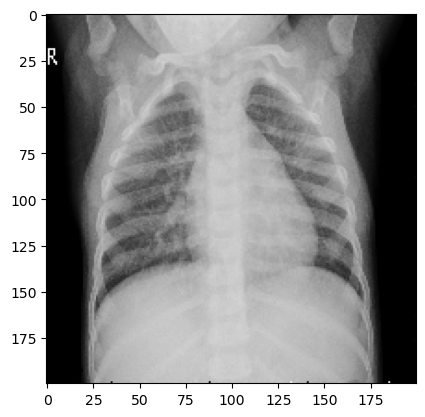

In [7]:
plt.imshow(train_images[3])

In [8]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        input_shape=(200, 200, 3)))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='sigmoid'))

model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 602176)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1204354   
Total params: 1,223,746
Trainable params: 1,223,746
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
model.fit(train_images, train_labels, epochs = 25, batch_size = 64)

Epoch 1/25
82/82 [==============================] - 8s 61ms/step - loss: 10.5400 - accuracy: 0.6541
Epoch 2/25
82/82 [==============================] - 4s 53ms/step - loss: 0.4272 - accuracy: 0.8025
Epoch 3/25
82/82 [==============================] - 4s 53ms/step - loss: 0.3415 - accuracy: 0.8704
Epoch 4/25
82/82 [==============================] - 4s 53ms/step - loss: 0.2772 - accuracy: 0.8980
Epoch 5/25
82/82 [==============================] - 4s 52ms/step - loss: 0.2415 - accuracy: 0.9112
Epoch 6/25
82/82 [==============================] - 4s 52ms/step - loss: 0.2114 - accuracy: 0.9178
Epoch 7/25
82/82 [==============================] - 4s 52ms/step - loss: 0.1947 - accuracy: 0.9270
Epoch 8/25
82/82 [==============================] - 4s 52ms/step - loss: 0.1755 - accuracy: 0.9304
Epoch 9/25
82/82 [==============================] - 4s 52ms/step - loss: 0.1864 - accuracy: 0.9270
Epoch 10/25
82/82 [==============================] - 4s 52ms/step - loss: 0.1774 - accuracy: 0.9333
Epoch 11